# HOMER DATA PROCESSING SCRIPT
The goal of this script is to take the output file of HOMER Pro Batch Runs (.xlsx file containing one optimal case/sheet) and produce a condensed data set + plots.

General flow:
1) Run HOMER study via batch process. Select "export results" and name the file.


2) Import file to this script.


3) Use Pandas to pull .xlsx data into a more usable format. 


4) Use collected data to build plots. 

Goals:


Have this script take a large HOMER study (>100 cases) and build one easily accessible database.


Potentially couple this script with a HOMER input reading script to do cartography w/HOMER geography + results.


In [14]:
# Block of dependencies and working directory
import matplotlib.pyplot as plt
import conda
import numpy  as np 
import pandas as pd
import os 
import shutil
directory = 'd:/repo/homer/ClimateStudies/OutputProcessing/Data' #home PC
#directory = 'c:/repo/homer/ClimateStudies/OutputProcessing/Data' #laptop

## Following this guide for xlsx reading
https://stackoverflow.com/questions/26521266/using-pandas-to-pd-read-excel-for-multiple-worksheets-of-the-same-workbook

In [21]:
# reads, maps all sheets 
files = os.listdir(directory)
output_df = {} #creates empty dictionary
names = [] #creates empty list for future name storage
for file in files:
    if file.endswith('.xlsx'):
        xls = pd.ExcelFile(directory + '/' + file) #reads file
        names = names + xls.sheet_names
        for sheet_name in xls.sheet_names: #pulls individual sheets
            output_df[sheet_name] = xls.parse(sheet_name) #puts each sheet into a dictionary w/key "sheet_name"
display(output_df[sheet_name])

,Architecture/PV\n(kW),Architecture/G1500,Architecture/GenLarge\n(kW),Architecture/1kWh LI,Cost/NPC\n($),Cost/COE\n($),Cost/Operating cost\n($/yr),Cost/Initial capital\n($),System/Ren Frac\n(%),System/Total Fuel\n(L/yr),...,GenLarge/Fuel Cost\n($/yr),PV/Capital Cost\n($),PV/Production\n(kWh/yr),G1500/Capital Cost\n($),G1500/Production\n(kWh/yr),G1500/O&M Cost\n($),1kWh LI/Autonomy\n(hr),1kWh LI/Annual Throughput\n(kWh/yr),1kWh LI/Nominal Capacity\n(kWh),1kWh LI/Usable Nominal Capacity\n(kWh)
0,16298.694992,11,1000.0,53081,181392912,0.149085,2996345.25,77237296,93.400429,595980.000,...,0.0,12224021.0,30395962,16912500,58277992,420750,10.616221,4923084.00,53081.105469,42464.886719
1,17069.391574,11,1000.0,52686,181967600,0.149553,3000124.25,77680624,93.443443,592110.000,...,0.0,12802044.0,31833258,16912500,58277992,420750,10.537221,4907318.50,52686.105469,42148.882812
2,16737.870084,11,1000.0,53523,182565424,0.150034,3016264.25,77717400,93.426773,593658.000,...,0.0,12553403.0,31214994,16912500,58277992,420750,10.704621,4917148.00,53523.105469,42818.484375
3,16766.892538,11,1000.0,53917,183104192,0.150471,3027272.25,77873520,93.429886,593400.000,...,0.0,12575169.0,31269118,16912500,58277992,420750,10.783422,4918428.00,53917.109375,43133.687500
4,16463.871520,11,1000.0,54425,183336736,0.150659,3035516.75,77819480,93.407181,595464.000,...,0.0,12347904.0,30704004,16912500,58277992,420750,10.885022,4923764.50,54425.109375,43540.085938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,8051.910201,5,4000.0,12516,214035792,0.175825,2187552.25,137994544,73.418716,2401817.500,...,0.0,6038932.5,15016267,7687500,26489996,191250,2.503205,4146715.75,12516.025391,10012.820312
1996,6918.159992,7,4000.0,11870,214036176,0.175806,2129900.50,139998944,77.009705,2077543.625,...,0.0,5188620.0,12901900,10762500,37085996,267750,2.374005,3854146.25,11870.023438,9496.018555
1997,11285.730447,5,4000.0,9422,214037024,0.175866,2148166.50,139364848,74.231461,2328224.750,...,0.0,8464298.0,21047122,7687500,26489996,191250,1.884404,3631524.75,9422.018555,7537.615234
1998,7592.209647,5,4000.0,12361,214040288,0.175827,2199120.25,137596912,72.966904,2442623.500,...,0.0,5694157.0,14158957,7687500,26489996,191250,2.472205,4144542.25,12361.024414,9888.819336


In [229]:
#pulling interesting data points from each 
opt_out = pd.DataFrame(columns=['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)','GenMin'])
new_cases = pd.DataFrame(columns=['FileName','CaseNum','Case1 LCOE','Case5 LCOE','Architecture/GenLarge\n(kW)'])
n = len(names)
display(n)
for i in range(n):
    name = names[i] # Grabs Sheet Name
    KCC = name[-3:]     #grabs KCC from last 3 values
    if KCC[-2:].casefold() == ('Af'.casefold()):
            KCC = 'Af'
            Location = name[6:-2]
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                case_num = name[:6] # Grabs Case Number 
            else:
                case_num = name[:5]
    elif KCC[-2:].casefold() == 'Am'.casefold():
            KCC = 'Am'
            Location = name[6:-2]
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                case_num = name[:6] # Grabs Case Number 
            else:
                case_num = name[:5]
    else: 
            Location = name[5:-3]
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                case_num = name[:6] # Grabs Case Number 
            else:
                case_num = name[:5]
    KCC = KCC.lower()
    filtered_out = output_df[name].filter(['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)']) #Filtering objects of interest
    filtered_out['CaseName'] = Location #adding actual case name to series
    filtered_out['CaseNum'] = case_num # adding case num to series
    filtered_out['KCC'] = KCC
    framed = filtered_out.iloc[[0]] #making the actual df
    framed.set_index(['CaseNum','CaseName'], inplace=True, drop=True) #building df w/ casename and num
    opt_out = pd.concat([framed,opt_out]) #concating all DFs together
  

    
# Data Cleanup    
opt_out = opt_out[ ['KCC'] + [ col for col in opt_out.columns if col != 'KCC' ] ] #sorting df to have KCC first
opt_out = opt_out.sort_index()
opt_out.to_excel("LocationalVarianceTrimmed.xlsx")


temp = pd.DataFrame(columns=['LocationName','Case1 LCOE','Case5 LCOE','Architecture/GenLarge\n(kW)'])
newopt_out = opt_out.reset_index()
newopt_out = newopt_out.set_index('CaseNum')
loc_list = newopt_out.loc['Case5']['CaseName'].tolist()
for i in range(0,len(loc_list)):
    loc_list[i] = loc_list[i].casefold()
display(loc_list)

folder = 'd:/repo/homer/ClimateStudies/ProductionCases/Case5'
files = [f for f in os.listdir(folder) if f.endswith('.homer')]
#display(files)
for i in range(1,len(opt_out.loc['Case5'])):
    filename = newopt_out.iloc[i]['CaseName'] + newopt_out.iloc[i]['KCC']
    case_num = newopt_out.iloc[i].index
    Location = newopt_out.iloc[i]['CaseName']
    if Location.casefold() not in loc_list:
        display(Location, 'is not needed anymore')
        #break
    else: 
        Case1LCOE = opt_out.loc['Case1'].loc[Location].loc['Cost/COE\n($)']
        Case5LCOE = opt_out.loc['Case5'].loc[Location].loc['Cost/COE\n($)']
        if opt_out.loc['Case5',Location].loc['Architecture/GenLarge\n(kW)'] >= 2000:
            if files[i].casefold() == ('Case5'+filename+'.homer').casefold():
                shutil.copyfile('d:/repo/homer/ClimateStudies/ProductionCases/Case5/' + files[i], directory + '/Case6/' + 'Case6' + files[i][5:])
                #display('Copied the file: ', files[i], 'to the new directory')
            temp.loc['LocationName'] = filename
            #temp.set_index(['LocationName'],drop=True,inplace=True) #
            temp['Case5 LCOE'] = opt_out.loc['Case5',Location].loc['Cost/COE\n($)']
            temp['Case1 LCOE'] = opt_out.loc['Case1',Location].loc['Cost/COE\n($)']
            temp['Architecture/GenLarge\n(kW)'] = opt_out.loc['Case5'].loc[Location].loc['Architecture/GenLarge\n(kW)']
        new_cases = pd.concat([temp,new_cases])
#new_cases=new_cases.sort_values(by='LocationName')
#new_cases.to_excel("NewCaseData6.xlsx")
#display(opt_out)
#display(new_cases)  

433

['azyuma',
 'anchorage',
 'ashland',
 'atlantaga',
 'bangorme',
 'bendore',
 'bentoncountyoregon',
 'birminghamal',
 'bismarcknd',
 'blainecountymontana',
 'boiseid',
 'brewsterma',
 'burlingtonvt',
 'buttonwillow',
 'carsoncitynv',
 'cheyennewy',
 'chicago',
 'coalvilleut',
 'columbiamo',
 'columbusoh',
 'crestedbutteco',
 'desmoinesia',
 'detroitmi',
 'eielsonafb',
 'flagstaff',
 'greatfallsmt',
 'idahofalls',
 'jacksonms',
 'kauai',
 'kootenaicountyid',
 'lancasterpa',
 'laredotx',
 'lincolnne',
 'littlerockar',
 'longview',
 'losalamosnm',
 'marlintonwv',
 'medfordor',
 'memphistn',
 'mobileal',
 'moscowid',
 'nola',
 'neahbay',
 'okcity',
 'ornl',
 'phoenixaz',
 'prescottaz',
 'pueblo',
 'raleighnc',
 'rapidcitysd',
 'reddingca',
 'richmondva',
 'sacramento',
 'southbendin',
 'syracuse',
 'texasoil',
 'upmich',
 'vegasnv',
 'wadenamn',
 'ilo',
 'verglades']

'YumaAZ'

'is not needed anymore'

'iami'

'is not needed anymore'

In [17]:
#for index = opt_out.ind
#display(pd.MultiIndex.get_level_values(opt_out('CaseNum')))
Case1 = opt_out.loc[("Case1",slice(None))]
Case2 = opt_out.loc[("Case2",slice(None))]
Case25 = opt_out.loc[("Case25",slice(None))]
Case3 = opt_out.loc[("Case3",slice(None))]
Case35 = opt_out.loc[("Case35",slice(None))]
Case4 = opt_out.loc[("Case4",slice(None))]
Case5 = opt_out.loc[("Case5",slice(None))]
display(Case4)
#Case1.plot(y='Cost/COE\n($)', use_index=True)

,KCC,Architecture/PV\n(kW),Architecture/G1500,Architecture/GenLarge\n(kW),Architecture/1kWh LI,Cost/COE\n($),GenMin
CaseName,,,,,,,
AZYuma,bwh,18946.593167,2.0,3000.0,34290,0.159500,NaN
Anchorage,dfc,21000.218750,NaN,4000.0,27500,0.201563,NaN
Ashland,dfb,28267.444075,8.0,3000.0,32379,0.171955,NaN
AtlantaGA,cfa,14683.409012,3.0,4000.0,26473,0.189311,NaN
BangorME,dfb,14034.944807,5.0,4000.0,27169,0.193386,NaN
...,...,...,...,...,...,...,...
Syracuse,dfb,32226.588138,6.0,3000.0,31696,0.178524,NaN
TexasOil,bsh,12331.998758,7.0,2000.0,35767,0.132140,NaN
UPMich,dfb,24484.569835,7.0,3000.0,34867,0.162385,NaN


<Figure size 432x288 with 0 Axes>

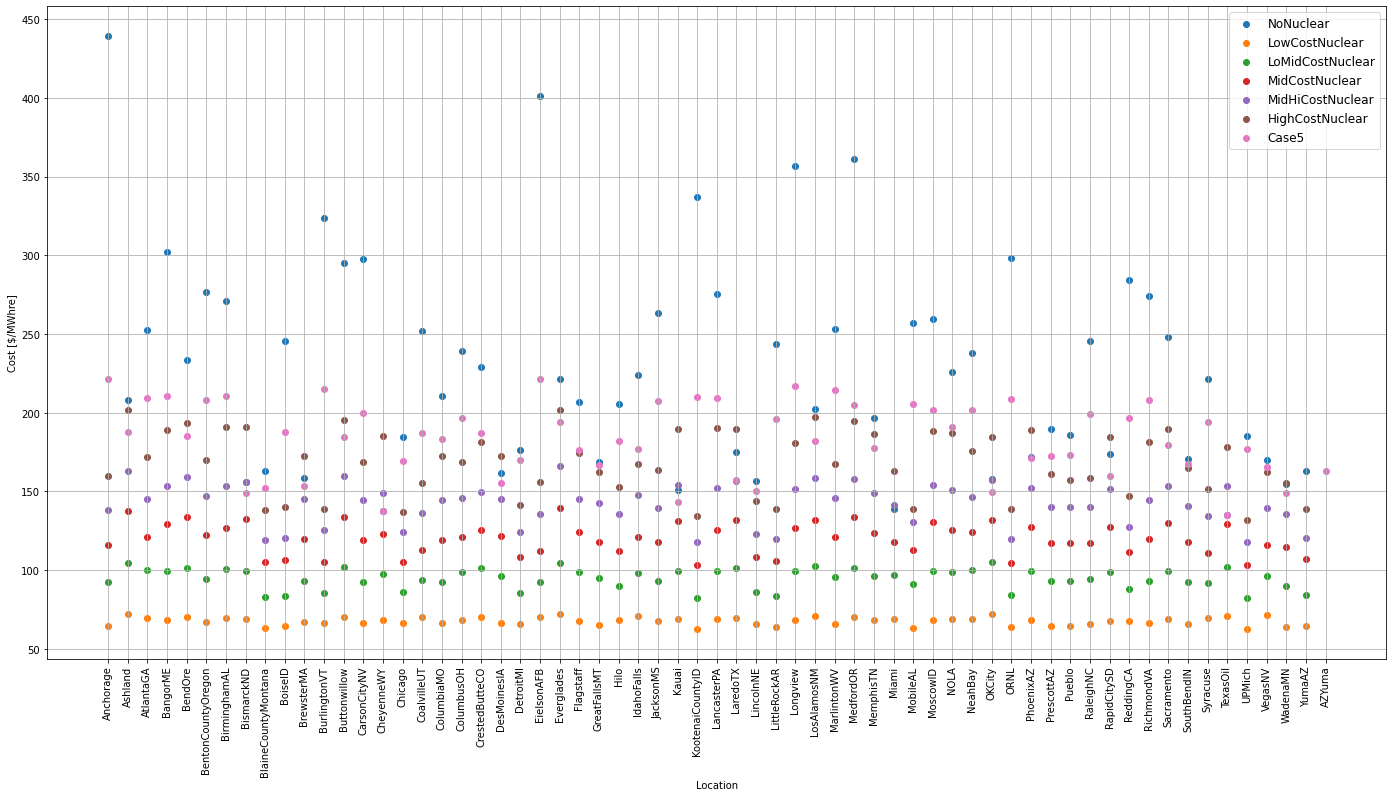

In [18]:
fig = plt.figure()
fig, ax=plt.subplots(figsize=(24,12))
ax.scatter(Case1.index.values,Case1['Cost/COE\n($)']*1000)
ax.scatter(Case1.index.values,Case2['Cost/COE\n($)']*1000)
ax.scatter(Case1.index.values,Case25['Cost/COE\n($)']*1000)
ax.scatter(Case1.index.values,Case3['Cost/COE\n($)']*1000)
ax.scatter(Case1.index.values,Case35['Cost/COE\n($)']*1000)
ax.scatter(Case1.index.values,Case4['Cost/COE\n($)']*1000)
ax.scatter(Case5.index.values,Case5['Cost/COE\n($)']*1000)
ax.legend(['NoNuclear', 'LowCostNuclear','LoMidCostNuclear', 'MidCostNuclear', 'MidHiCostNuclear','HighCostNuclear', 'Case5'], fontsize='large')
plt.ylabel('Cost [\$/MWhre]')
plt.xlabel('Location')
plt.xticks(rotation=90);
ax.grid(True)


NameError: name 'bars25' is not defined

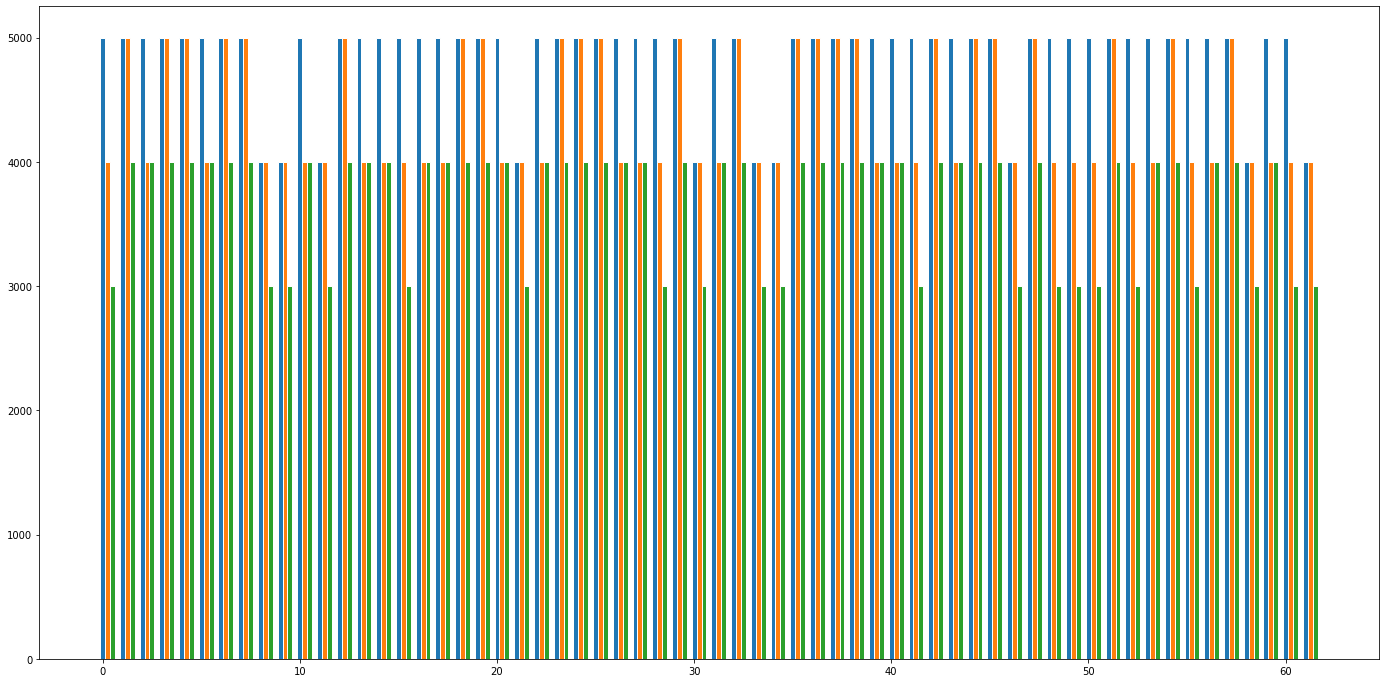

In [19]:
m = len(Case2)
fig = plt.figure(figsize=(24,12))
barWidth = 0.25
# Grabbing Generator Size Data
bars1 = Case2["Architecture/GenLarge\n(kW)"]
bars15 = Case25["Architecture/GenLarge\n(kW)"]
bars2 = Case3["Architecture/GenLarge\n(kW)"]
bars2 = Case35["Architecture/GenLarge\n(kW)"]
bars3 = Case4["Architecture/GenLarge\n(kW)"]
#ranges
r1 = np.arange(m)
r15 = [x+barWidth for x in r1]
r2 = [x+barWidth for x in r15]
r25 = [x+barWidth for x in r2]
r3 = [x+barWidth for x in r25]

# Plotting
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='LowCostNuclear')
plt.bar(r15, bars15, width=barWidth, edgecolor='white', label='LoMidCostNuclear')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='MidCostNuclear')
plt.bar(r25, bars25, width=barWidth, edgecolor='white', label='MidCostNuclear')
plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='HighCostNuclear')
# Add xticks on the middle of the group bars
plt.xlabel('Location', fontweight='bold')
plt.ylabel('Microreactor Capacity [MW]', fontweight='bold')
plt.xticks([r + barWidth for r in range(m)], Case2.index.values)
plt.xticks(rotation=90);
plt.grid(True)
 
